# Cointegration Relationships

Here I take a look at the impact of the window lengths used. This can be seen in the rainbow colored plots. Blue represent a shorter window, and red a longer window.

In [1]:
import numpy as np
import pandas as pd

import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
# Just set the seed for the random number generator
np.random.seed(107)

import matplotlib.pyplot as plt
%matplotlib inline

import pandas_datareader.data as web
import scipy as sp
from scipy import stats
from matplotlib import style
import seaborn

from mpl_toolkits.mplot3d import Axes3D

from pykalman import KalmanFilter

import itertools

In [2]:
style.use('seaborn-poster')
style.use('seaborn-whitegrid')
style.use('seaborn-notebook')

In [3]:
pairs_to_check = [('TSL','SOL'),('REGI','BLDP'),('TSL','CSUN'),
                  ('JASO','OPTT'),('CSUN','YGE'),('JASO','GEVO'),('REGI','FSLR'),('JASO','BLDP')]

In [4]:
symbols_test = ['BLDP','REGI','FSLR','CSUN','TSL','YGE','JASO','GEVO','OPTT','SOL']
prices_test = web.DataReader(symbols_test, data_source='yahoo',
                        start='2015-01-01', end='2016-01-01')[('Adj Close')]

In [12]:
def run_pair_coint_summary(pair_data):
    s1 = pair_data.iloc[:,0]
    s2 = pair_data.iloc[:,1]
    
    print('pair: (',pair_data.columns.tolist()[0],', ',pair_data.columns.tolist()[1], ')')
    
    score, p_value, _ = coint(s1, s2)
    print('Cointegration p_value over given data: ', p_value)

    # Kalman Cointegration Beta
    delta = 1e-8\2
    trans_cov = delta / (1 - delta) * np.eye(2) # How much random walk wiggles
    obs_mat = np.expand_dims(np.vstack([[s1.values], [np.ones(len(s1))]]).T, axis=1)

    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional ,(alpha, beta) is 2-dimensional
                      initial_state_mean=[0,0],
                      initial_state_covariance=np.ones((2, 2)),
                      transition_matrices=np.eye(2),
                      observation_matrices=obs_mat,
                      observation_covariance=2,
                      transition_covariance=trans_cov)
    # Use the obsercations y to get running estimates and errors for the state parameters
    state_means, state_covs = kf.filter(s2.values)
    
    
    
    fig, axarr = plt.subplots(4, sharex=True, figsize=(10,14))
    axarr[0].plot(s1.index, state_means[:,0], label='Kalman Coint Beta')
    axarr[0].legend();
#     axarr[1].plot(s1.index, state_means[:,1], label='intercept')
#     axarr[1].legend()
    # plt.tight_layout()
    
    spread = s2 - state_means[:,0] * s1
    spread.name = 'spread'

    # Construct a Kalman Filter
    kf = KalmanFilter(transition_matrices = [1],
                      observation_matrices = [1],
                      initial_state_mean = 0,
                      initial_state_covariance = 1,
                      observation_covariance = 1,
                      transition_covariance = 0.1)

    # Use the observed values of the price to get a rolling mean
    state_means2, _ = kf.filter(spread.values)

    kalman_spread = pd.Series(state_means2.flatten(), index=spread.index)
    kalman_spread.name = 'Kalman Spread'


    # Get the 1 day moving average of the price spread
    spread_mavg1 = spread.rolling(window=1).mean()
    spread_mavg1.name = 'spread 1d mavd'

    # Get the 30 day moving average
    spread_mavg30 = spread.rolling(window=30).mean()
    spread_mavg30.name = 'spread 30d mavg'


    axarr[1].plot(kalman_spread, alpha=0.75)
    axarr[1].plot(spread_mavg1.index, spread_mavg1.values, alpha=0.75)
    axarr[1].plot(spread_mavg30.index, spread_mavg30.values, alpha=0.75)

    axarr[1].legend([kalman_spread.name, '1 Day, Spread MAVG', '30 Day, Spread MAVG'])

    # axarr[2].ylabel('Spread')
    
    # Take a rolling 30 dy standard deviation
    std_30 = spread.rolling(window=30).std()
    std_30.name = 'std 30d'

    # Compute the z score for each day
    zscore_30_kalman = (kalman_spread - spread_mavg30)/std_30
    zscore_30_kalman.name = 'z-score Kalman'
    zscore_30_kalman.plot(ax=axarr[2], alpha=0.8)
    zscore_30_unfiltered = (spread - spread_mavg30)/std_30
    zscore_30_unfiltered.name = 'z-score unfiltered'
    zscore_30_unfiltered.plot(ax=axarr[2], alpha=0.8)
    axarr[2].axhline(0, color='black')
    axarr[2].axhline(1.0, color='red', linestyle='--')
    axarr[2].axhline(-1.0, color='green', linestyle='--')
    
    
    
    plot_1 = axarr[3].axhline(1.0, color='red', linestyle='--', alpha=0.75)
    axarr[3].axhline(-1.0, color='green', linestyle='--', alpha=0.75);
    axarr[3].legend(['+1 $\sigma$', '-1 $\sigma$'], loc='best');
    
    cm = plt.get_cmap('jet') 
    # cNorm  = colors.Normalize(vmin=1, vmax=90)
    # scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    
    window_lens = range(5, 120, 2)
    colors = np.linspace(0.1, 1, len(window_lens))
    
    # Plot every fifth line
#     step = 2
#     colors_1 = np.linspace(0.01, 1, 44)
    
    # x = spread.index
    # y = range(1,90)

    for i in range(len(window_lens)):
        # compute a rolling moving ave of spread
        ave_spread = spread.rolling(window=window_lens[i]).mean()
        ave_spread.name = 'spread ' + str(window_lens[i]) + ' d mavg'
        
        std_roll = spread.rolling(window=window_lens[i]+5).std() #### NOTE THE SHIFT OF + 5 ######
        std_roll.name = 'std ' + str(window_lens[i]) + 'd'
        
#         colorVal = scalarMap.to_rgba(i)
        
        zscore_window = (kalman_spread - ave_spread)/std_roll
        zscore_window.name = 'z-score Kalman'
        # if i == 30:
        axarr[3].plot(zscore_window.index, zscore_window.values, c=cm(colors[i]), alpha=0.4)
#         zscore_window.plot(ax=axarr[3], c=cm(colors[i]), alpha=0.8)
#         zscore_30_unfiltered = (spread - ave_spread)/std_roll
#         zscore_30_unfiltered.name = 'z-score unfiltered'
#         zscore_30_unfiltered.plot(ax=axarr[2], alpha=0.8)
        
#     cb = plt.colorbar(mappable=cm, ax=axarr[3])            ### NOT QUITE SURE HOW TO GET ACCURATE COLORBAR HERE
#     cb.ax.set_yticklabels([str(i) for i in window_lens])
    
    total_zscore = (spread - spread.mean())/spread.std()
    axarr[3].plot(total_zscore.index, total_zscore.values, c='k', alpha=0.7)
    # axarr[3].set_ylim((-15,15))
    
        
        
        
        # plt.plot(xi, beta[0]*xi+beta[1], alpha=0.2, lw=1, c=cm(colors_1[i]))
    
    
    
    # Plot the prices scaled down along with the negative z-score
    # just divide the stock price by 10 to make viewing it on the plot easier
#     axarr[3].plot(s1.index, s1.values, alpha=0.75)
#     axarr[3].plot(s2.index, s2.values, alpha=0.75)
#     axarr[3].plot(zscore_30_kalman.index, zscore_30_kalman.values, alpha=0.75)
#     axarr[3].axhline(1.0, color='red', linestyle='--', alpha=0.75)
#     axarr[3].axhline(-1.0, color='green', linestyle='--', alpha=0.75);
#     axarr[3].legend(['s1 Price', 's2 Price', 'Price Spread Rolling z-score']);

SyntaxError: unexpected character after line continuation character (<ipython-input-12-2131225a0ea0>, line 11)

In [8]:
s1 = prices_test.loc[:,pairs_to_check[0][0]]
s2 = prices_test.loc[:,pairs_to_check[0][1]]

print('pair: (',pairs_to_check[0][0],', ',pairs_to_check[0][1], ')')

score, p_value, _ = coint(s1, s2)
print('Cointegration p_value over given data: ', p_value)

# Kalman Cointegration Beta
delta = 1e-3
trans_cov = delta / (1 - delta) * np.eye(2) # How much random walk wiggles
obs_mat = np.expand_dims(np.vstack([[s1.values], [np.ones(len(s1))]]).T, axis=1)

kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional ,(alpha, beta) is 2-dimensional
                  initial_state_mean=[0,0],
                  initial_state_covariance=np.ones((2, 2)),
                  transition_matrices=np.eye(2),
                  observation_matrices=obs_mat,
                  observation_covariance=2,
                  transition_covariance=trans_cov)
# Use the obsercations y to get running estimates and errors for the state parameters
state_means, state_covs = kf.filter(s2.values)

pair: ( TSL ,  SOL )
Cointegration p_value over given data:  0.17267443084


/Users/kennypotts/anaconda/envs/python3/lib/python3.5/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


In [9]:
kf.filter_update?

pair: ( TSL ,  SOL )
Cointegration p_value over given data:  0.17267443084


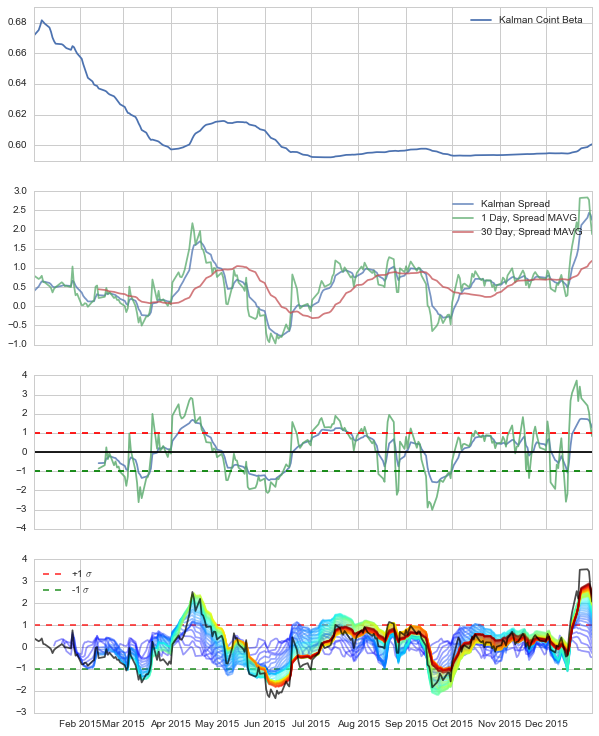

In [11]:
run_pair_coint_summary(prices_test.loc[:,pairs_to_check[0]])

pair: ( TSL ,  SOL )
Cointegration p_value over given data:  0.17267443084


/Users/kennypotts/anaconda/envs/python3/lib/python3.5/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


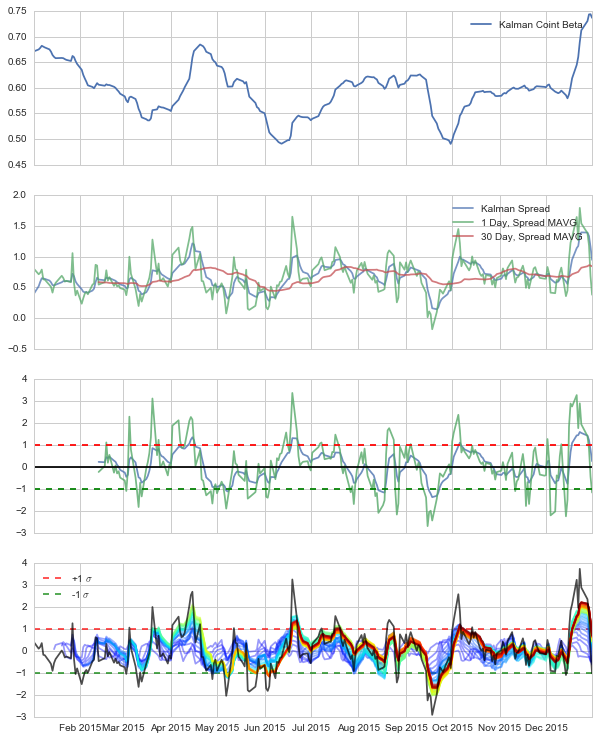

In [7]:
run_pair_coint_summary(prices_test.loc[:,pairs_to_check[0]])

pair: ( REGI ,  BLDP )
Cointegration p_value over given data:  0.496049917425


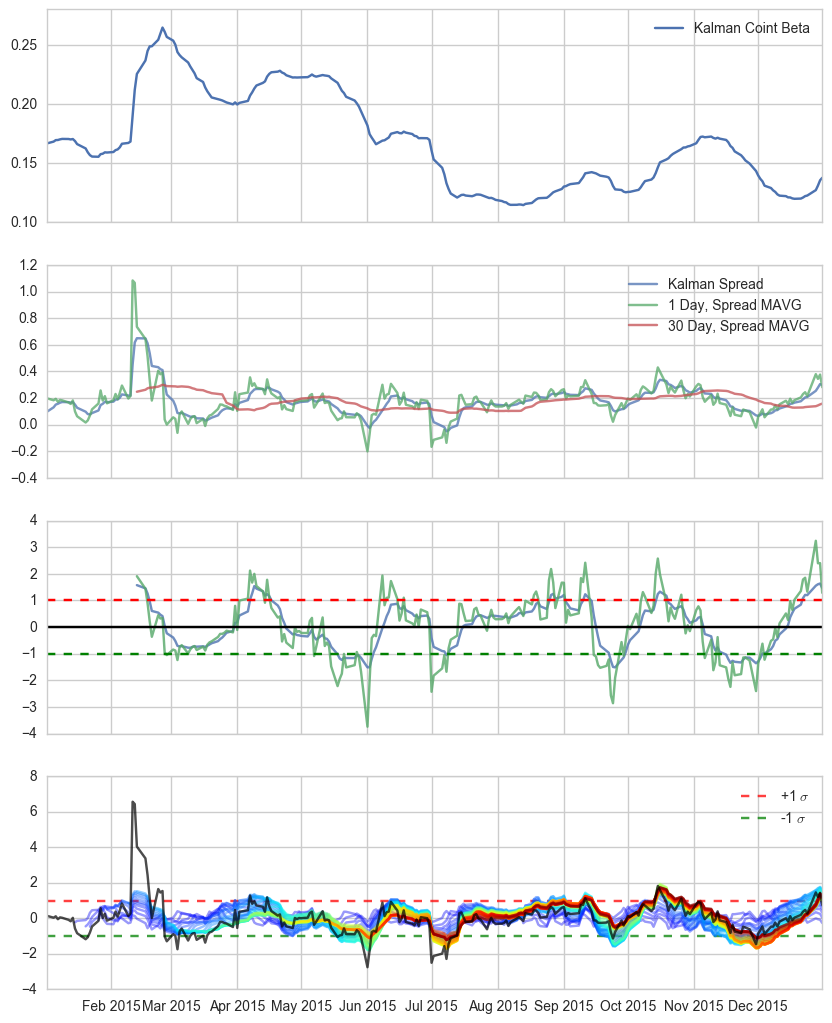

In [9]:
run_pair_coint_summary(prices_test.loc[:,pairs_to_check[1]])

pair: ( TSL ,  CSUN )
Cointegration p_value over given data:  0.74637213811


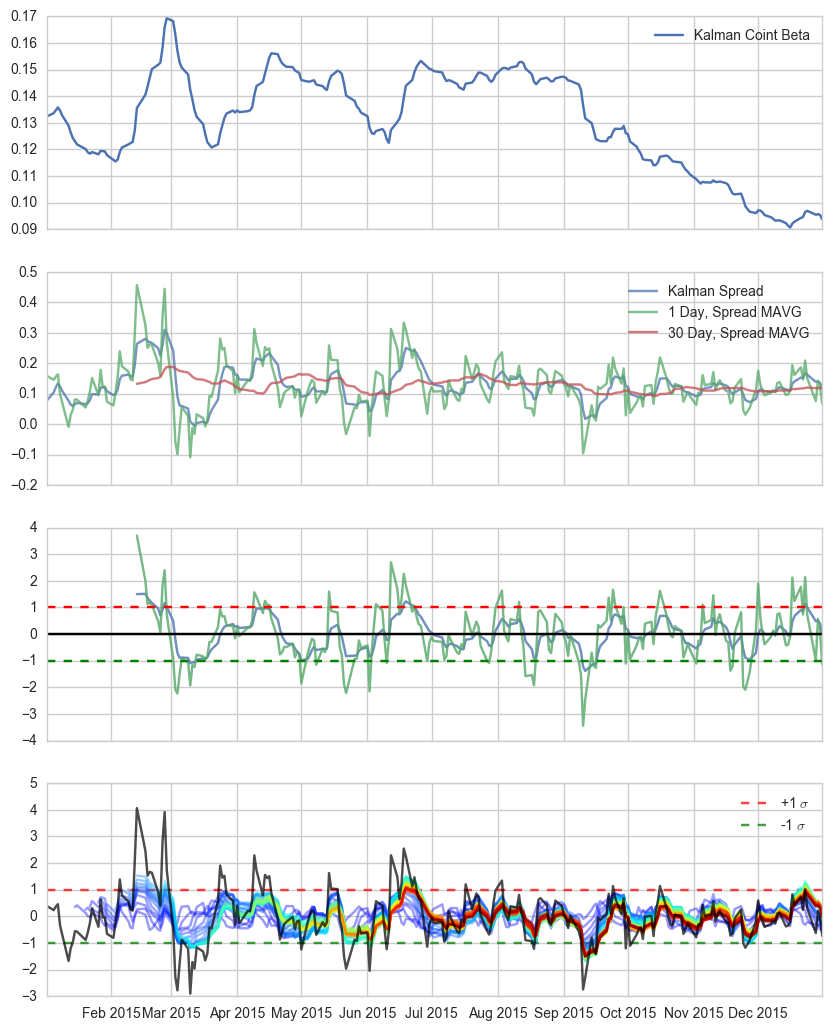

In [10]:
run_pair_coint_summary(prices_test.loc[:,pairs_to_check[2]])

pair: ( JASO ,  OPTT )
Cointegration p_value over given data:  0.705809507293


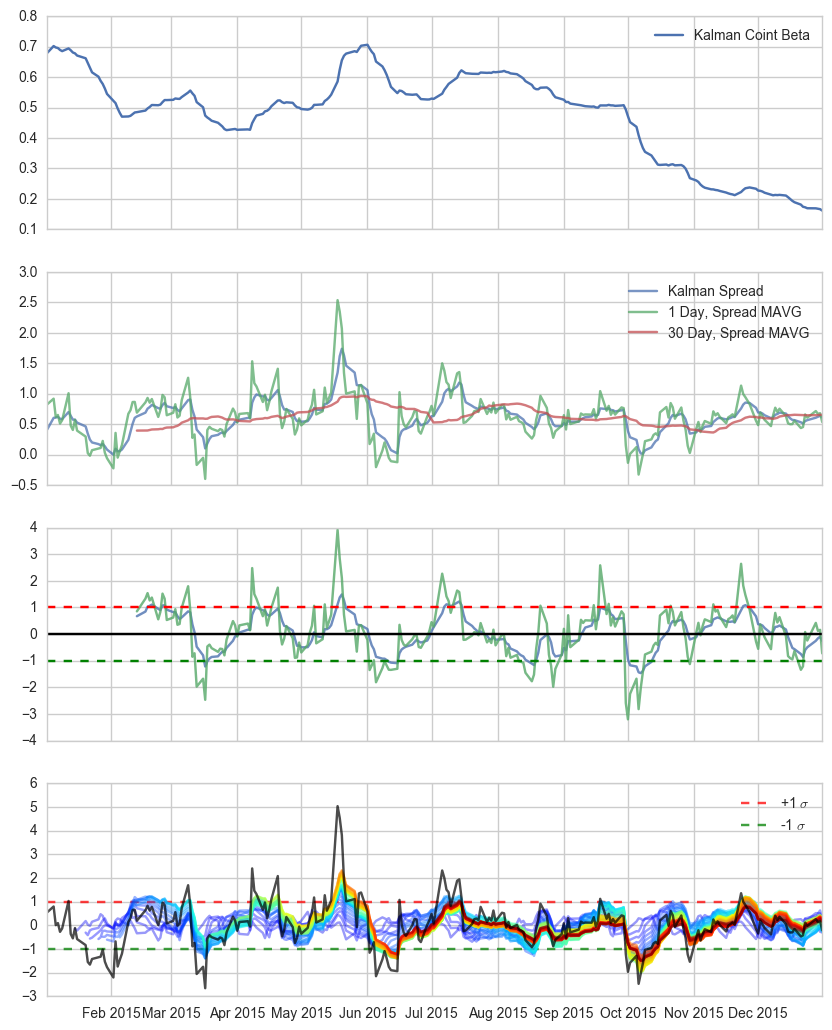

In [11]:
run_pair_coint_summary(prices_test.loc[:,pairs_to_check[3]])

pair: ( CSUN ,  YGE )
Cointegration p_value over given data:  0.418026401792


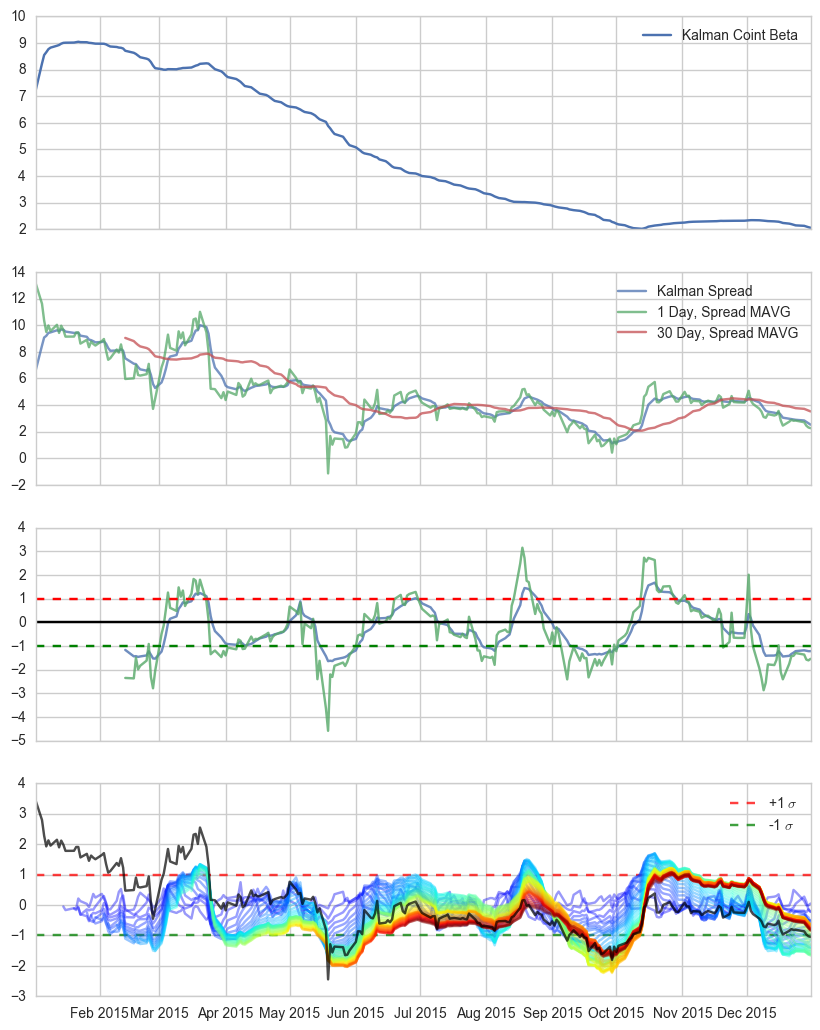

In [12]:
run_pair_coint_summary(prices_test.loc[:,pairs_to_check[4]])

pair: ( JASO ,  GEVO )
Cointegration p_value over given data:  0.69946056302


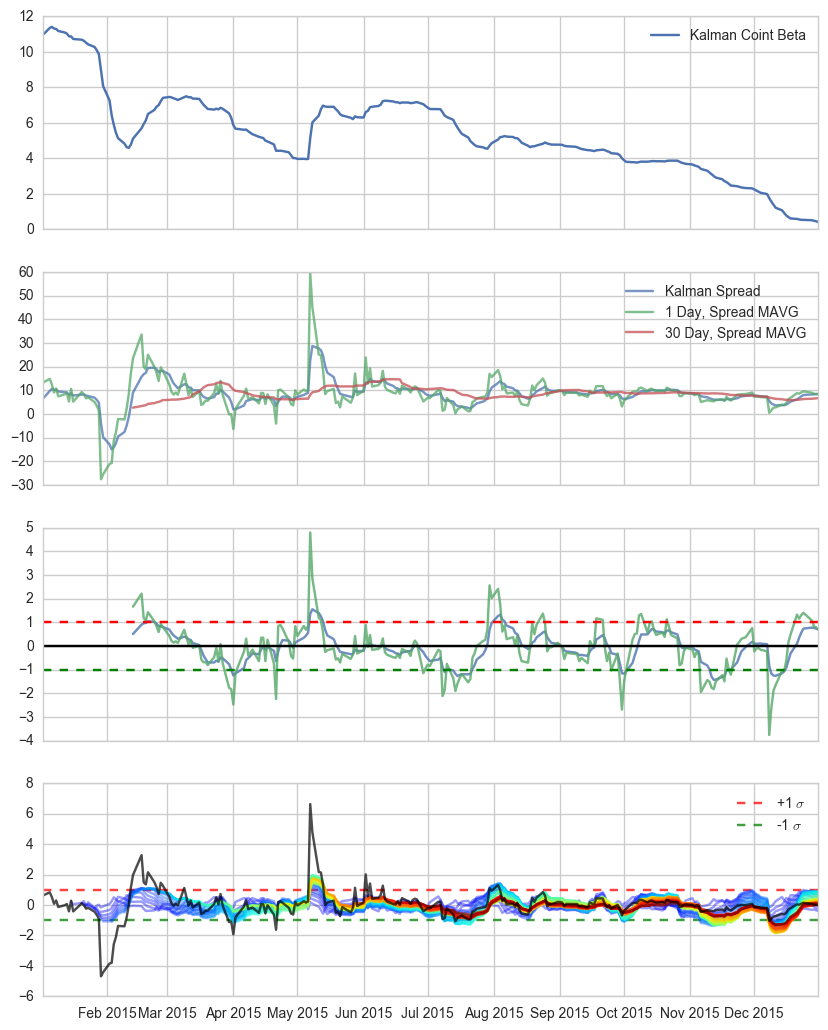

In [13]:
run_pair_coint_summary(prices_test.loc[:,pairs_to_check[5]])

pair: ( REGI ,  FSLR )
Cointegration p_value over given data:  0.558556126711


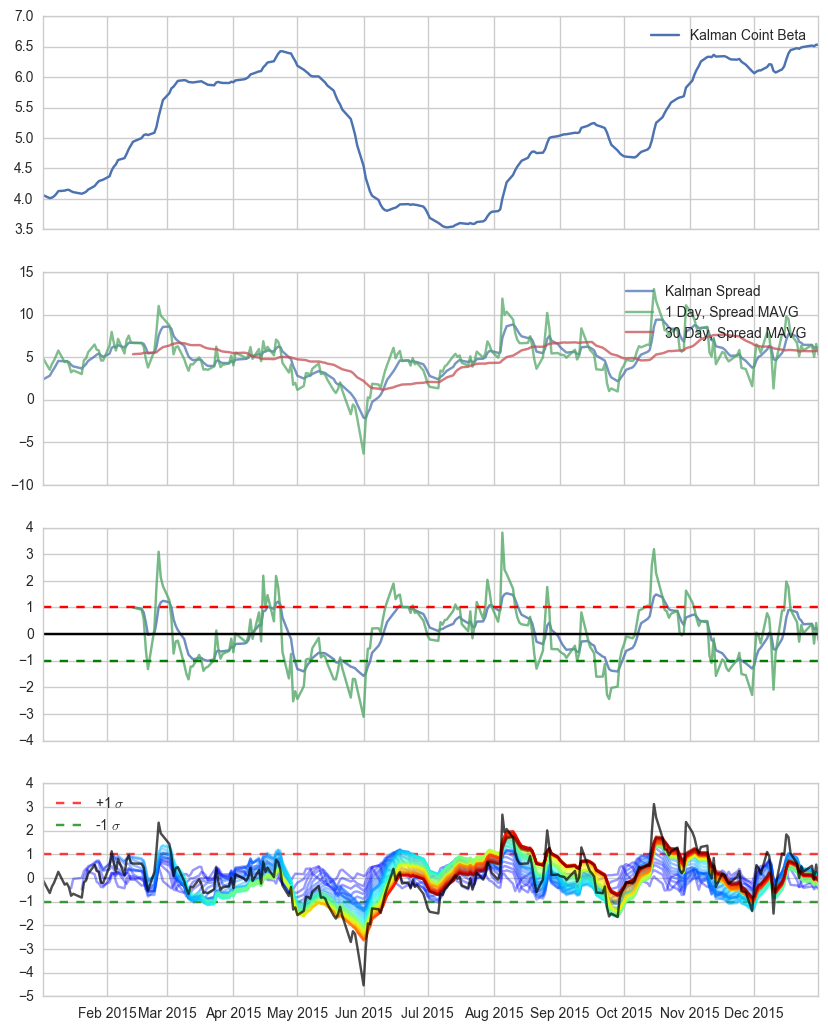

In [14]:
run_pair_coint_summary(prices_test.loc[:,pairs_to_check[6]])